<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/collab_nn_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0" #use the old version

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 50.8MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [3]:
from fastai import *
from fastai.collab import *

In [4]:
!pip install ipdb

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10973 sha256=9b17d76f3142ddbcd0b84bdb45e663f452655342ef22cbb6a3943176d807dc54
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [5]:
from ipdb import set_trace as st

In [6]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cd ml-1m
!pwd

--2020-12-20 06:08:56--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  6.73MB/s    in 0.8s    

2020-12-20 06:08:57 (6.73 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
/content


In [7]:
path = Path('/content/ml-1m') 
path.ls()

[PosixPath('/content/ml-1m/README'),
 PosixPath('/content/ml-1m/users.dat'),
 PosixPath('/content/ml-1m/movies.dat'),
 PosixPath('/content/ml-1m/ratings.dat')]

In [9]:
ratings = pd.read_csv(path/'ratings.dat', delimiter= '::', encoding = 'latin-1', header = None, names = ['user_id', 'movie_id', 'rating', 'ts'])
movies = pd.read_csv(path/'movies.dat', delimiter= '::', encoding= 'latin-1', header = None, names = ['movie_id', 'movie', 'geners'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [10]:
ratings.head()

,user_id,movie_id,rating,ts
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
movies.head() 

,movie_id,movie,geners
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movie_ratings = ratings.merge(movies, left_on= 'movie_id', right_on='movie_id')
movie_ratings.head()

,user_id,movie_id,rating,ts,movie,geners
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [14]:
bs = 64
data = CollabDataBunch.from_df(movie_ratings , user_name='user_id', item_name= 'movie', rating_name='rating', bs = bs)
data.show_batch()

user_id,movie,target
1181,Nighthawks (1981),2.0
535,Galaxy Quest (1999),4.0
225,Man Bites Dog (C'est arrivé près de chez vous) (1992),4.0
1449,Dancer in the Dark (2000),4.0
5691,"Wedding Singer, The (1998)",4.0


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


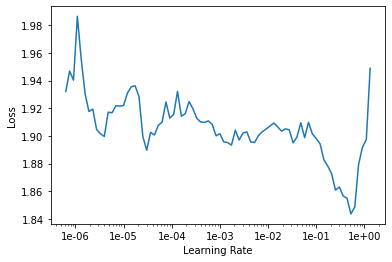

In [15]:
learn = collab_learner(data, n_factors= 40, y_range = [0., 5.5])
learn.lr_find()
learn.recorder.plot(skip_end= 10)

In [16]:
learn.fit_one_cycle(2, 9e-03)

epoch,train_loss,valid_loss,time
0,0.987562,0.973540,01:03
1,0.735859,0.796177,01:02


In [17]:
class EDB(nn.Module):

  def __init__(self, nu, ni, nf, y_range):
    super().__init__()
    self.y_range = y_range
    self.u_w, self.i_w, self.u_b, self.i_b = [nn.Embedding(*x) for x in [(nu, nf), (ni, nf), (nu, 1), (ni, 1)]]
  
  def forward(self, users, items):
    dot = self.u_w(users) * self.i_w(items)
    res = dot.sum(1) + self.u_b(users).squeeze(1) + self.i_b(items).squeeze(1)
    return torch.sigmoid(res)*y_range[1] + y_range[0]

In [18]:
nu, ni, nf, y_range = len(data.x.classes['user_id']), len(data.x.classes['movie']), 40, [0., 5.5]

In [19]:
model = EDB(nu, ni, nf, y_range).cuda()

In [20]:
for i in model.parameters():
  print(i.shape)

torch.Size([6041, 40])
torch.Size([3686, 40])
torch.Size([6041, 1])
torch.Size([3686, 1])


In [21]:
loss_func = learn.loss_func

In [22]:
import statistics

In [24]:
model = EDB(nu, ni, nf, y_range).cuda()
optimizer = optim.Adam(model.parameters(), lr = 6e-03, momentum = 0.9)
c = 0
losses = []
e = 7
while e >= 0:
  for x, y in data.train_dl:
    optimizer.zero_grad()
    y_hat = model(*x)
    loss = loss_func(y_hat, y)
    loss.backward()
    optimizer.step()
    c += 1
    if c%5000 == 0:
      print(loss.item())
    losses.append(loss.item())
  e -= 1
  print(f'Average mean for epoc: {7-e} is {statistics.mean(losses)}')
  losses = []

6.361891746520996
5.485948085784912
Average mean for epoc: 1 is 5.3919510788735225
3.4964840412139893
2.91939115524292
3.2455124855041504
Average mean for epoc: 2 is 3.2181520398626935
1.8645029067993164
1.719012975692749
Average mean for epoc: 3 is 2.033644449012868
1.4496265649795532
1.515934944152832
1.2346709966659546
Average mean for epoc: 4 is 1.461947190668121
1.3530030250549316
1.1524101495742798
Average mean for epoc: 5 is 1.236501846513144
1.0142433643341064
1.085806131362915
1.3948466777801514
Average mean for epoc: 6 is 1.1284124815326713
1.6418955326080322
0.7161968946456909
Average mean for epoc: 7 is 1.070438890178439
0.7914189100265503
1.034062147140503
1.1236083507537842
Average mean for epoc: 8 is 1.0398628147430105


In [22]:
for batch in data.train_dl:
  break
u, i = batch[0]
y = batch[1]

In [23]:
model = learn.model
model.__dict__

{'_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('u_weight', Embedding(6041, 40)),
              ('i_weight', Embedding(3675, 40)),
              ('u_bias', Embedding(6041, 1)),
              ('i_bias', Embedding(3675, 1))]),
 '_parameters': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 'training': False,
 'y_range': [0.0, 5.5]}

In [25]:
params = []
for i in model.parameters():
  params.append(i)
params[0].shape

torch.Size([6041, 40])

In [25]:
torch.mean(params[0]), torch.std(params[0]), torch.mean(params[2]), torch.std(params[2])

(tensor(-0.0047, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2205, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.1990, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2621, device='cuda:0', grad_fn=<StdBackward0>))

In [26]:
n_model = model = EDB(nu, ni, nf, y_range).cuda()
torch.mean(n_model.u_w.weight), torch.std(n_model.u_w.weight), torch.mean(n_model.i_w.weight), torch.std(n_model.i_w.weight)

(tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9987, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(-0.0024, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9998, device='cuda:0', grad_fn=<StdBackward0>))

In [27]:
n_learn = collab_learner(data, n_factors= 40, y_range = [0., 5.5])
new_params = []

for i in n_learn.model.parameters():
  new_params.append(i)
torch.mean(new_params[0]), torch.std(new_params[0]), torch.mean(new_params[2]), torch.std(new_params[2])

(tensor(-1.7457e-05, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0087, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(-6.3940e-05, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0086, device='cuda:0', grad_fn=<StdBackward0>))

In [33]:
1. -1.7457e-05, 1. -6.3940e-05

(0.999982543, 0.99993606)

In [65]:
math.sqrt(5.)

2.23606797749979

In [28]:
#test


tensor([[ 1.1348, -0.2441,  0.8195,  0.4311,  1.3768],
        [-1.4104,  1.2685, -1.1772,  1.4026, -2.1436],
        [-1.0180, -0.6123,  1.2245,  0.9331,  0.2532]])


(tensor(0.1492), tensor(1.1698))

In [30]:
nn.init.kaiming_uniform_(w, a = math.sqrt(5), mode='fan_in', nonlinearity='relu')
print(w, w.mean(), w.std())
torch.mean(w), torch.std(w)

tensor([[ 0.8000,  0.8419,  0.9478, -0.1901,  0.7816],
        [-0.2616, -0.6666, -0.9656,  0.9526,  0.9633],
        [-0.1488,  0.1081,  0.7782, -0.5330, -0.6388]]) tensor(0.1846) tensor(0.7068)


(tensor(0.1846), tensor(0.7068))

In [38]:

a = math.sqrt(5)
gain = math.sqrt(2/(1 + a**2))

0.5773502691896257

In [46]:
w = torch.randn(3, 5)
fan = nn.init._calculate_correct_fan(w, 'fan_in')
gain = nn.init.calculate_gain('leaky_relu', math.sqrt(5))
# fan, gain
std = gain/math.sqrt(fan)
# std, fan, gain
bound = math.sqrt(3) * std
std, fan, gain, bound

(0.2581988897471611, 5, 0.5773502691896257, 0.44721359549995787)

In [47]:
print(torch.mean(w), torch.std(w))
w.uniform_(-bound, bound)
print(torch.mean(w), torch.std(w))

tensor(-0.0485) tensor(1.0980)
tensor(-0.0293) tensor(0.3018)


In [66]:
class EDB_NN(nn.Module):

  def __init__(self, nu, ni, nf, y_range):
    super().__init__()
    self.y_range = y_range
    self.u_w, self.i_w = [nn.Embedding(*x) for x in [(nu, nf), (ni, nf)]]
    self.w = nn.Linear(nf, 1, bias = True)

  def forward(self, users, items):
    res = self.w(self.u_w(users) * self.i_w(items))
    return torch.sigmoid(res)*y_range[1] + y_range[0]

In [67]:
newm = EDB_NN(nu, ni, nf, y_range).cuda()
yhat = newm(*x)

In [68]:
yhat.shape, y.shape

(torch.Size([64, 1]), torch.Size([64]))

In [69]:
loss = loss_func(y_hat, y)
loss

tensor(0.5286, device='cuda:0', grad_fn=<MseLossBackward>)

In [70]:
model = EDB_NN(nu, ni, nf, y_range).cuda()
optimizer = optim.Adam(model.parameters(), lr = 9e-03)
c = 0
losses = []
e = 2
while e >= 0:
  for x, y in data.train_dl:
    optimizer.zero_grad()
    y_hat = model(*x)
    loss = loss_func(y_hat, y)
    loss.backward()
    optimizer.step()
    c += 1
    if c%5000 == 0:
      print(loss.item())
    losses.append(loss.item())
  e -= 1
  print(f'Average mean for epoc: {7-e} is {statistics.mean(losses)}')
  losses = []

1.065464735031128
1.6436424255371094
Average mean for epoc: 6 is 1.2825727221956635
1.2617601156234741
1.2321463823318481
0.7678769826889038
Average mean for epoc: 7 is 1.1800807996800071
0.9783095121383667
0.9127510190010071
Average mean for epoc: 8 is 0.8916966381182272


In [71]:
model = EDB_NN(nu, ni, nf, y_range).cuda()
learn = CollabLearner(data, model)
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


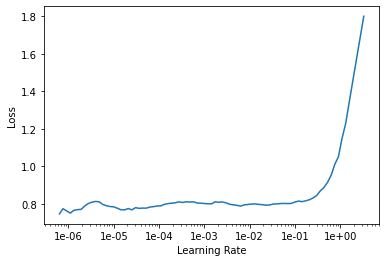

In [72]:
learn.recorder.plot(skip_ends = 20)

In [73]:
learn.fit_one_cycle(2, 9e-03)

epoch,train_loss,valid_loss,time
0,0.831444,0.829462,01:01
1,0.744288,0.804601,01:00


In [76]:
m = learn.model

Parameter containing:
tensor([[-0.1197, -0.1998,  0.0434, -0.0044, -0.3200, -0.1041, -0.1512, -0.0354,
          0.0025,  0.1019,  0.0880,  0.0130,  0.6431, -0.1753,  0.0877, -0.2104,
          0.0479, -0.0333, -0.1333, -0.0278, -0.0052, -0.1298,  0.0137, -0.0184,
         -0.1217, -0.1001,  0.0373,  0.1790,  0.0791,  0.0294, -0.1575,  0.1668,
          0.1178, -0.0646,  0.0811, -0.0506, -0.0011, -0.1921, -0.1183, -0.4595]],
       device='cuda:0', requires_grad=True)

In [79]:
torch.mean(m.u_w.weight), torch.std(m.u_w.weight), torch.mean(m.i_w.weight), torch.std(m.i_w.weight), torch.mean(m.w.weight), torch.std(m.w.weight)

(tensor(-0.0091, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5104, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(-0.0140, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4802, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(-0.0300, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.1694, device='cuda:0', grad_fn=<StdBackward0>))

In [80]:
m = EDB_NN(nu, ni, nf, y_range).cuda()
torch.mean(m.u_w.weight), torch.std(m.u_w.weight), torch.mean(m.i_w.weight), torch.std(m.i_w.weight), torch.mean(m.w.weight), torch.std(m.w.weight)

(tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9966, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(0.0035, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0027, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(-0.0209, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0838, device='cuda:0', grad_fn=<StdBackward0>))